# Themal Simulations of Water Distribution Networks
WNTR recently included a `ThermalSimulator` to simulate temperature dynamics within water distribution networks. New properties and methods were added to the `Node`, `Link`, `Junction`, `Tank`, `Reservoir`, `Pipe`, `Pump` , and `Valve` classes to handle thermophysical properties of the water pipes and the surrounding soil on the object level. Additionally, new classes like `Weather` and `ThermalOptions` were added to handle global properites defined on network level. The following tutorial explains how to use the new simulator and the newly defined properties and classes through an example.

## 1- Quick Start
The thermal simulator uses flow rates, demands, leak-demands, and water levels in tanks derived from the hydraulic simulation to calculate nodal temperatures at each time step. Thus, hydraulic results need to be first generated before running a thermal simulation.

In [1]:
import wntr
from numpy import array, sin, pi
from numpy.random import rand
import matplotlib.pylab as plt
%matplotlib inline

# Create a WaterNetworkModel from an EPANET INP file
wn = wntr.network.WaterNetworkModel('networks/Net3.inp')

# Simulate hydraulics using the WNTRSimulator and store results
sim = wntr.sim.WNTRSimulator(wn)
results = sim.run_sim()

for more details about running thermal simulations please refer to the `basic_tutorial.ipynb` demo.

As a quick start, a thermal simulation can be run directly at this stage using the results of the hydraulic simulation. In this thermal simulation, the default values for thermophysical properties and boundary conditions will be used to calculate nodal temperatures.

In [2]:
# Run thermal simulation using the ThermalSimulator and add nodal temperatures to the results
Tsim = wntr.sim.ThermalSimulator(wn, results)
results = Tsim.run_sim() 

Now the `resutls.node` have 2 new dataframes namely `temperature` and `soil_temperature` that hold the nodal temperatures for water and soil, respectively. Results can be plotted as follows:

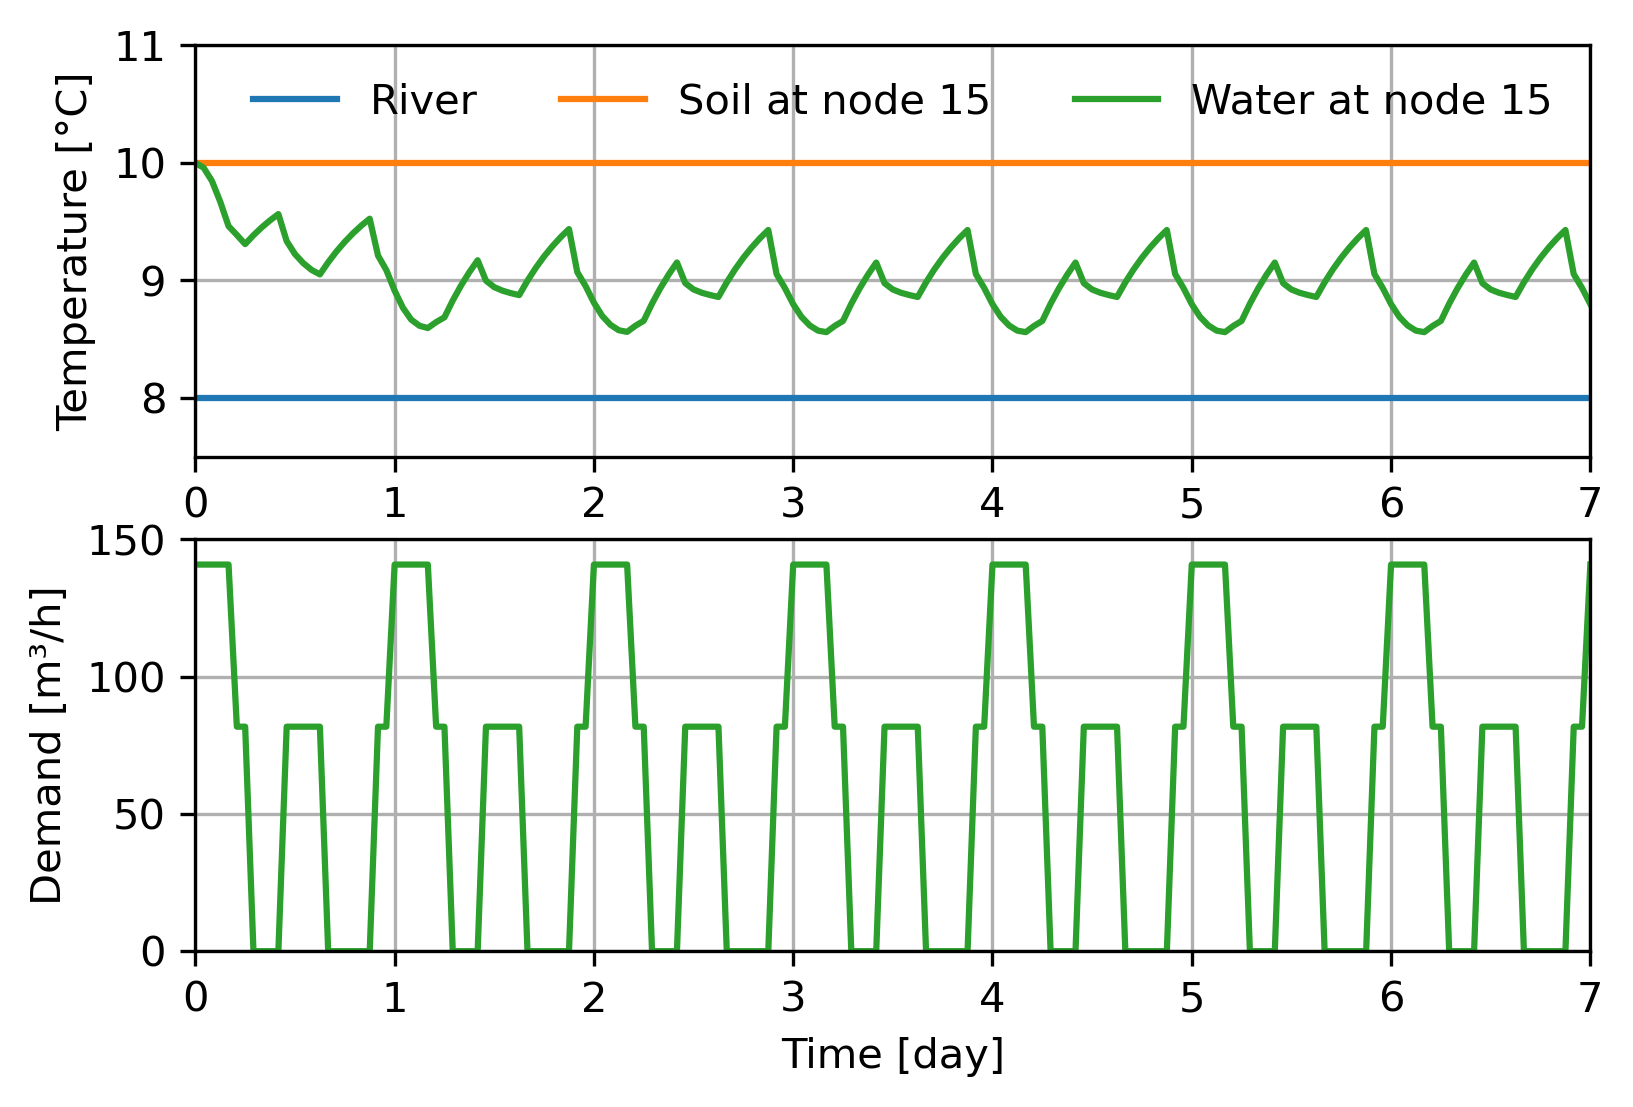

In [3]:
# Plot results for node '15'
T_water = results.node['temperature']
T_soil  = results.node['soil_temperature']
demand  = results.node['demand']*3600
time = array(T_water.index/3600/24)

fig, ax = plt.subplots(2,1, figsize=(6,4), dpi=300)
plt.subplot(2,1,1)
plt.plot(time, T_water['River'], time, T_soil['15'], time, T_water['15'])
plt.ylabel('Temperature [°C]')
plt.legend(['River','Soil at node 15', 'Water at node 15'],ncols=3,frameon=False)
plt.axis([0,7,7.5,11])
plt.grid(visible=True)

plt.subplot(2,1,2)
plt.plot(time, demand['15'],'tab:green')
plt.xlabel('Time [day]'); plt.ylabel('Demand [m³/h]')
plt.grid(visible=True)
plt.axis([0,7,0,150])
plt.show()

## 2- Define Boundary Conditions, Initial Conditions and Material Properties
### 2.1- Inlet Boundary Conditions
The thermal simulator takes the water temperature at the reservoir(s) as inlet boundary condition(s). By default the temperature of any reservoir node is set to 8 °C and to modify it, users need to give a base value and a multiplier pattern:

In [4]:
# Assume a base temperature and a sinusoidal pattern (or use measured values)
base_T = 1.0
T_pattern_name = 'T_reservoir'
T_pattern_multipliers = 0.02*sin(2*pi*time-0.25)-0.5*time/time.max()+10

# Add pattern to the WaterNetworkModel's registery
wn.add_pattern(T_pattern_name, T_pattern_multipliers)

# Use the assumed values as inlet boundary conditions
for reservoir_name in wn.reservoir_name_list:
    wn.nodes[reservoir_name].base_temperature = base_T
    wn.nodes[reservoir_name].temperature_pattern_name = T_pattern_name

### 2.2 Wall Boundary Conditions
There are 3 types of wall boundary conditions that the thermal simulator accepts:
- `pipe`: (Default) The temperature at the outer walls of the pipes
- `soil`: The underground temperature at a shallower depth than the pipes
- `air` : The weather data at the ground surface 

Nodes with `pipe` wall boundary condition should have the temperature of the soil (at the outer wall of the pipe) as a given. Since this temperature can change from one location to another, the model allows users to define a temperature timeseries for each node. This is done using the `soil_props` property as follows:


In [5]:
for node_name in wn.node_name_list:
    # Assume a base temperture and a pattern for each node (or used measured values)
    base_Tp = 1.0
    Tp_pattern_name = f'T_pipe_at{node_name}'
    Tp_pattern_multipliers = 0.1*rand(time.size)*sin(2*pi*time-0.25)-time/time.max()+5.0
    
    # Add pattern to WaterNetworkModel's registery:
    wn.add_pattern(Tp_pattern_name, Tp_pattern_multipliers)
    
    # Use the assumed values as wall boundary conditions
    wn.nodes[node_name].soil_props.base_temperature = base_Tp
    wn.nodes[node_name].soil_props.temperature_pattern_name = Tp_pattern_name

here, the `rand` function is used to generate a different pattern for each node. However, if measured values are availble for each node, they can be used instead. When such measurements are not available, users can change the type of wall boundary conditions to `soil` or `air`, then input weather data instead. 

Users can define wall boundary conditions to different nodes using the `thermal_bc` property under each node:

In [6]:
# Define soil boundary condition for node 105 and air boundary condition for node 115:
wn.nodes['105'].thermal_bc = 'soil'
wn.nodes['115'].thermal_bc = 'air'

# Check which type of wall boundary conditions does node 15 have by default:
wn.nodes['15'].thermal_bc

'pipe'

Each type of wall boudnary condition uses different thermal model to calculate the temperatures of water (and soil) at each node.

To change weather data for nodes with `air` or `soil` boundary conditions, a `Weather` object should be created and modified. This object will then be passed to the `ThermalSimulator`.

In [7]:
# Assume a pattern for shallow soil temperature (or use measured values)
Ts_pattern_name = 'T_soil'
Ts_pattern_multipliers = 0.1*rand(time.size)*sin(2*pi*time-0.25)-time/time.max()+5.0

# Assume a pattern for air temperature (or use measured values)
Ta_pattern_name = 'T_air'
Ta_pattern_multipliers = 2*rand(time.size)*sin(2*pi*time-0.25)-1.5*time/time.max()

# Assume a pattern for wind speed (or use measured values)
v_pattern_name = 'wind_speed'
v_pattern_multipliers = rand(time.size)*sin(2*pi*time-0.25)+4.0

# Assume a pattern for global solar radiation (or use measured values)
G_pattern_name = 'global_solar_radiation'
G_pattern_multipliers = 0.5*sin(2*pi*time-0.25)-rand(time.size)
G_pattern_multipliers[G_pattern_multipliers<0]=0

# Add patterns to WaterNetworkModel's registery
wn.add_pattern(Ts_pattern_name, Ts_pattern_multipliers)
wn.add_pattern(Ta_pattern_name, Ta_pattern_multipliers)
wn.add_pattern(v_pattern_name, v_pattern_multipliers)
wn.add_pattern(G_pattern_name, G_pattern_multipliers)

# Create a Weater object
weather = wntr.network.elements.Weather(wn)

# Change properites that affect the results of nodes having 'soil' wall boundary conditions
weather.base_soil_temperature = 1.0
weather.soil_temperature_pattern_name = Ts_pattern_name
weather.depth_of_soil_temperature_device = 0.05

# Change properites that affect the results of nodes having 'air' wall boundary conditions
weather.base_air_temperature = 1.0
weather.air_temperature_pattern_name = Ta_pattern_name

weather.base_wind_speed = 1.0
weather.wind_speed_pattern_name = v_pattern_name

weather.base_global_solar_radiation = 1.0
weather.global_solar_radiation_pattern_name = G_pattern_name

It is important to note that, the `Weather` object is defined on the network level, which means it is neither node nor link specific. To put local changes in soil composition into account, the `soil_props` can be changed for each node as follows:

In [8]:
# Change base values for soil properties (add patterns if necessary)
wn.nodes['105'].soil_props.base_thermal_conductivity = 1.2
wn.nodes['105'].soil_props.base_volumetric_heat_capacity = 20e5

wn.nodes['115'].soil_props.base_thermal_conductivity = 1.1
wn.nodes['115'].soil_props.base_volumetric_heat_capacity = 21e5
wn.nodes['115'].soil_props.base_absorptivity = 0.8 

### 2.3 Initial Conditions
At time 0, the initial water temperature at all junctions and tanks nodes should be privided. Additinally, if any of these nodes use `soil` or `air` wall boundary condition, the initial soil temperature should be provided. By default both temperatures are assumed to have a value of 10 °C. Modifications can be done as follows:

In [9]:
for node_name in wn.junction_name_list + wn.tank_name_list:
    wn.nodes[node_name].initial_temperature = 7

wn.nodes['105'].soil_props.base_soil_temeprature = 5.0
wn.nodes['115'].soil_props.base_soil_temeprature = 5.0

### 2.4 Water Thermophysial properities
In the `ThermalOptions` class created under the `Options` module allows users to change the heat capacity of water. By default it is set to 4180 J/kg K. 

In [10]:
wn.options.thermal.heat_capacity = 4200

Additionally the thermal model uses the `specific_gravity` in the `HydraulicOptions` to calculate the density of water. No thermal conductivity is defined for water since the model assumes negligible conductive heat transfer.

# 3- Rerun the Thermal Simulation and Print Results

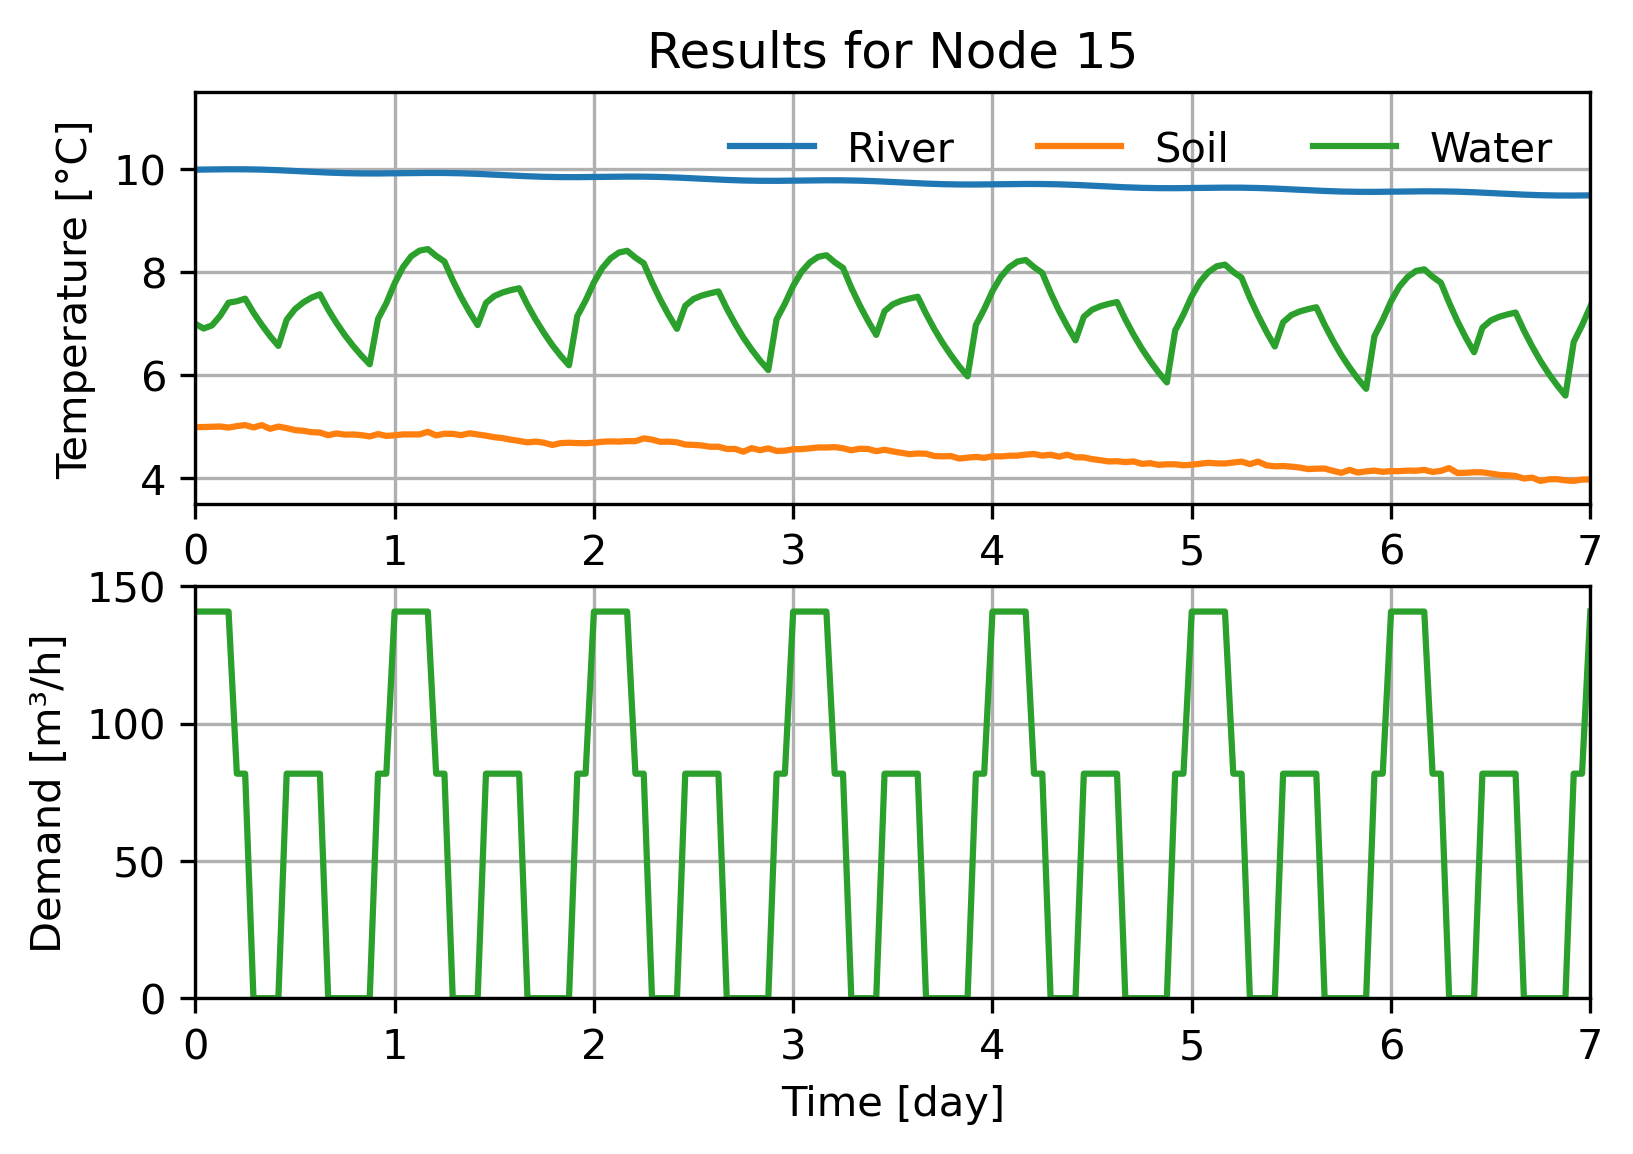

In [25]:
# Rerun the thermal simulation. This time with the weather data given
Tsim = wntr.sim.ThermalSimulator(wn, results, weather)
results = Tsim.run_sim()

# Replot results for node '15'
Tw = results.node['temperature']
Ts  = results.node['soil_temperature']

fig, ax = plt.subplots(2,1, figsize=(6,4), dpi=300)
plt.subplot(2,1,1)
plt.plot(time, Tw['River'], time, Ts['15'], time, Tw['15'])
plt.ylabel('Temperature [°C]')
plt.legend(['River','Soil', 'Water'],ncols=3,frameon=False)
plt.axis([0,7,3.5,11.5])
plt.grid(visible=True)
plt.title('Results for Node 15')

plt.subplot(2,1,2)
plt.plot(time, demand['15'],'tab:green')
plt.xlabel('Time [day]'); plt.ylabel('Demand [m³/h]')
plt.grid(visible=True)
plt.axis([0,7,0,150])
plt.show()

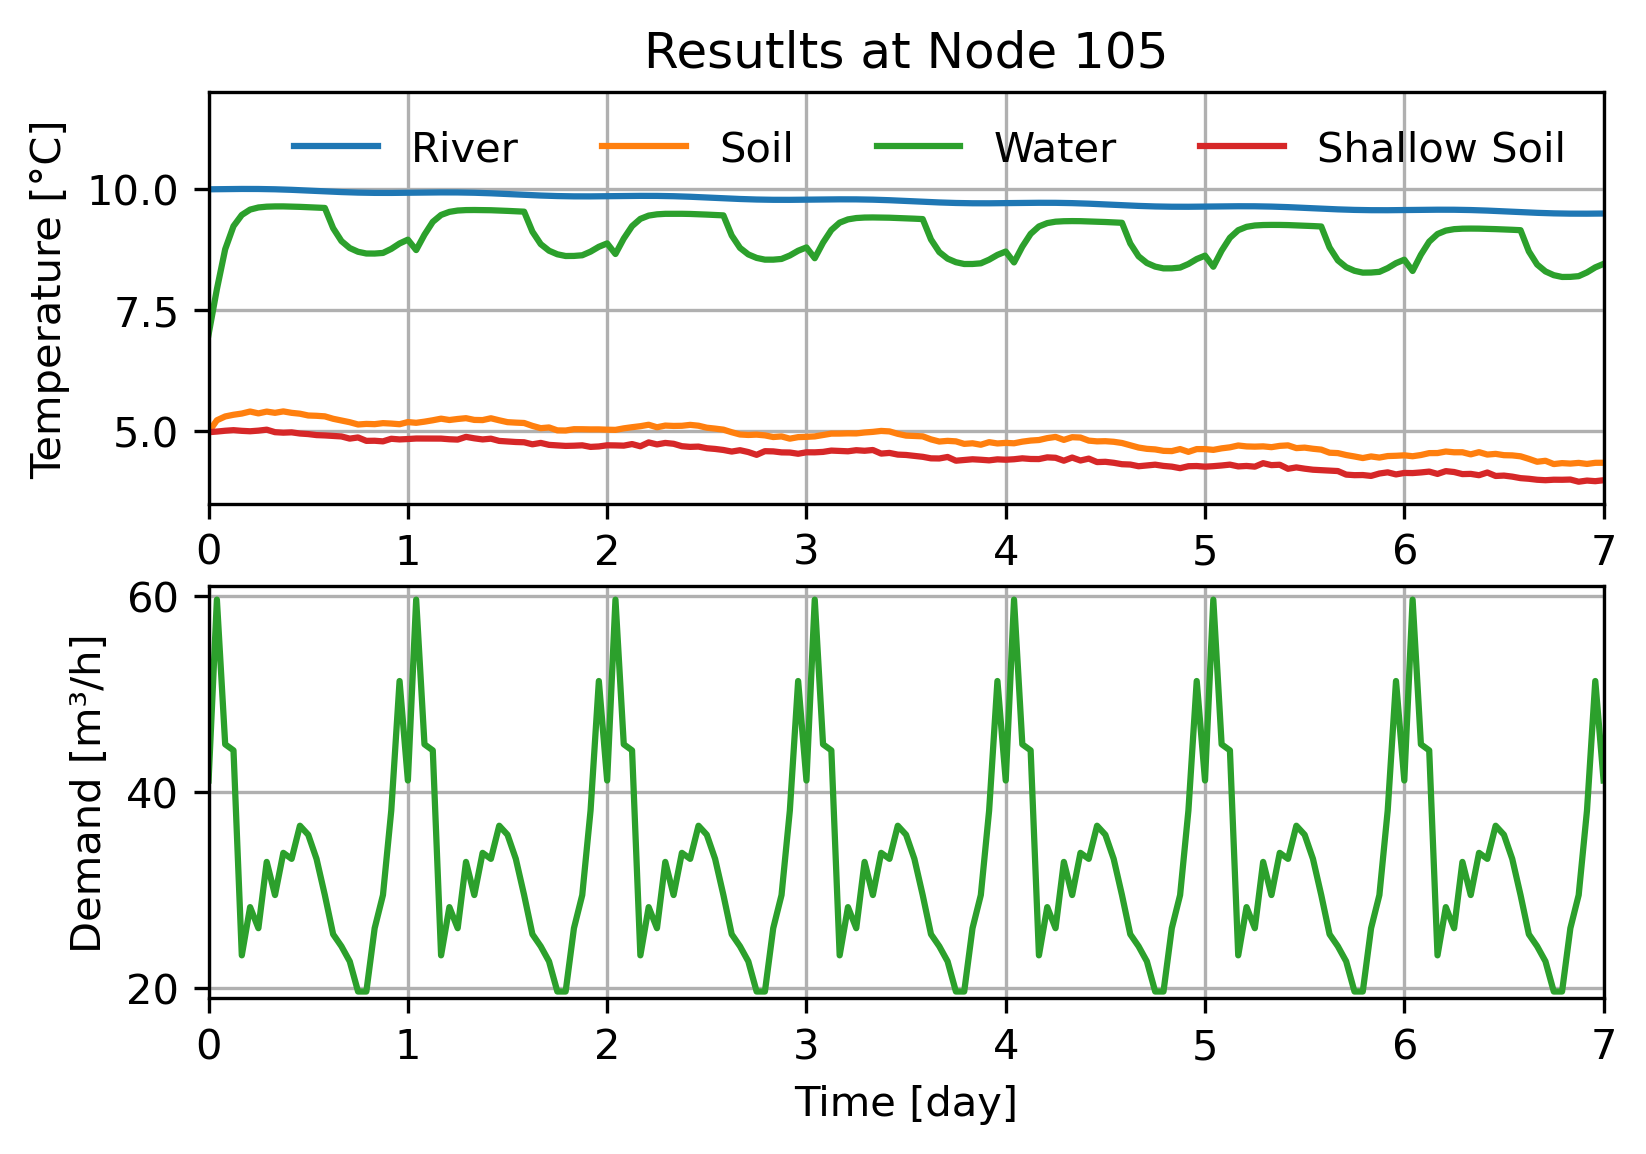

In [28]:
fig, ax = plt.subplots(2,1, figsize=(6,4), dpi=300)
plt.subplot(2,1,1)
plt.plot(time, Tw['River'], time, Ts['105'], time, Tw['105'], time, Ts_pattern_multipliers)
plt.ylabel('Temperature [°C]')
plt.legend(['River','Soil', 'Water', 'Shallow Soil'],ncols=4,frameon=False)
plt.axis([0,7,3.5,12])
plt.grid(visible=True)
plt.title('Resutlts at Node 105')

plt.subplot(2,1,2)
plt.plot(time, demand['105'],'tab:green')
plt.xlabel('Time [day]'); plt.ylabel('Demand [m³/h]')
plt.grid(visible=True)
plt.axis([0,7,19,61])
plt.show()

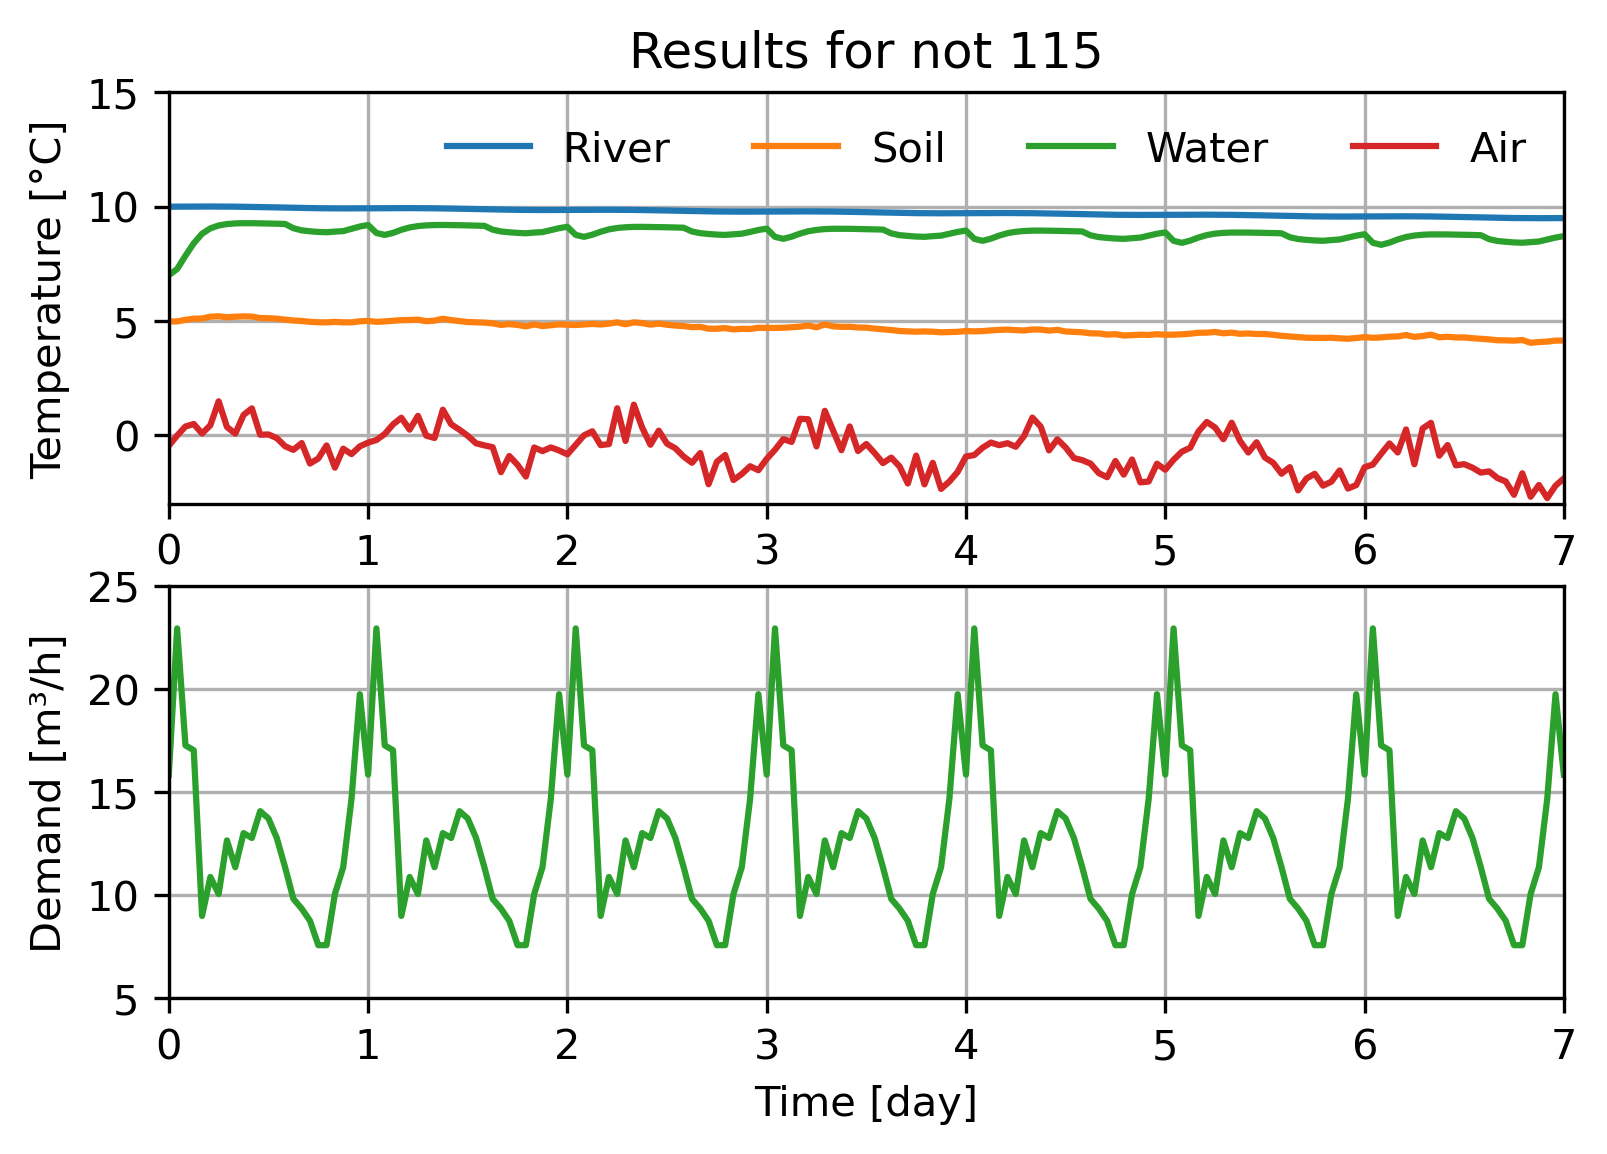

In [22]:
fig, ax = plt.subplots(2,1, figsize=(6,4), dpi=300)
plt.subplot(2,1,1)
plt.plot(time, Tw['River'], time, Ts['115'], time, Tw['115'], time, Ta_pattern_multipliers)
plt.ylabel('Temperature [°C]')
plt.legend(['River','Soil', 'Water', 'Air'],ncols=4,frameon=False)
plt.axis([0,7,-3,15])
plt.grid(visible=True)
plt.title('Results for not 115')

plt.subplot(2,1,2)
plt.plot(time, demand['115'],'tab:green')
plt.xlabel('Time [day]'); plt.ylabel('Demand [m³/h]')
plt.grid(visible=True)
plt.axis([0,7,5,25])
plt.show()